[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Dilru1/ner-project/blob/main/ner-project.ipynb)


# Named Entity Recognition (NER) Systems

Project Overview: Building and comparing RNN-based (LSTM) and Transformer-based (BERT) models for named entity recognition on the CONLL-03 dataset.

* **GitHub Repository**: [https://github.com/Dilru1/ner-project.git](https://github.com/Dilru1/ner-project.git)
* **Open in Colab**: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Dilru1/ner-project/blob/main/ner-project.ipynb)


### Author
* **DEHIWALAGE DON** Dilruwan (ENSAI)


---

## 0.1 Setup and Environment
This project requires a Python environment with PyTorch, Transformers (Hugging Face), and Scikit-Learn installed. The following cell imports the necessary libraries and verifies the installed versions to ensure reproducibility.

In [1]:
import sys
import os
from pathlib import Path
import urllib.request

import json
import gzip
import sklearn
import torch
import transformers
from transformers import AutoModel, AutoTokenizer  #`transformers` provides the pre-trained DistilBERT model and tokenizer.
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset, DataLoader

print("--- Library Versions ---")
print(f"Python:       {sys.version.split()[0]}")
print(f"PyTorch:      {torch.__version__}")
print(f"Transformers: {transformers.__version__}")
print(f"Scikit-Learn: {sklearn.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Device:   {torch.cuda.get_device_name(0)}")


#project root 
project_root = os.getcwd()

/home/ensai/miniconda3/envs/torchgpu/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--- Library Versions ---
Python:       3.13.9
PyTorch:      2.9.1+cu128
Transformers: 4.57.5
Scikit-Learn: 1.8.0
CUDA Available: True
GPU Device:   NVIDIA RTX 1000 Ada Generation Laptop GPU


## 0.2 Data Exploration 

In [164]:
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns



Before building the models, it is essential to understand the structure and characteristics of the CONLL-03 dataset. In this section, we will:

1.  **Verify Dataset Splits:** Check the size of the training, validation, and test sets.
2.  **Inspect Samples:** Visualize how sentences and named entity tags are structured (IOB format).
3.  **Analyze Class Distribution:** Examine the frequency of each tag (PER, ORG, LOC, MISC) to detect potential class imbalances that might affect training.

In [2]:
if "COLAB_GPU" in os.environ:
    url = "https://raw.githubusercontent.com/Dilru1/ner-project/main/data/conll03-iob-pos.json.gz"
    data_path = Path("conll03-iob-pos.json.gz")
    if not data_path.exists():
        urllib.request.urlretrieve(url, data_path)
else:
    project_root = Path.cwd()
    data_path = project_root / "data" / "conll03-iob-pos.json.gz"

with gzip.open(data_path, "rt", encoding="utf-8") as f:
    data = json.load(f)

for fold in ("train", "valid", "test"):
    print(fold, len(data[fold]))

train 14041
valid 3250
test 3453


In [166]:
# check a arbitary sample of data
sample_idx = 10
sample = data['train'][sample_idx]

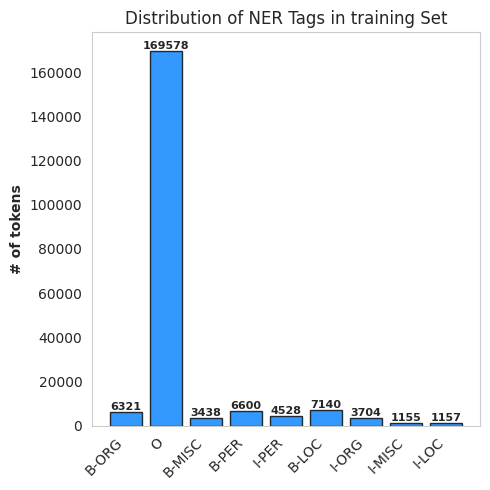

In [167]:
all_tags = [tag for sample in data['train'] for tag in sample['tags']] # flatten the tags
tag_counts = Counter(all_tags)

tags = list(tag_counts.keys())
counts = list(tag_counts.values())

sns.set_style("whitegrid")
plt.figure(figsize=(5,5))

colors = ["#fc0000" if tag == 'PER' else "#0080ff" for tag in tags]
bars = plt.bar(tags, counts, color=colors, edgecolor='black', alpha=0.8)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 5, str(height),
             ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.xticks(rotation=45, ha="right", fontsize=10)
plt.ylabel("# of tokens", fontsize=10, fontweight='bold')
plt.title("Distribution of NER Tags in training Set", fontsize=12)
plt.tight_layout()
plt.grid(False)
plt.show()


*Observations*
1.  *Class Imbalance:* The **'O' (Outside)** tag dominates the dataset. Non-entities make up the vast majority of tokens. Hence a model trained with standard accuracy as the sole metric might converge to a local minimum and it may predicts 'O' for everything.


In the example below, we demonstrate this behavior using the word "embedding". BERT splits it into smaller units, adding `##` to indicate that a token is a suffix of the preceding part.

In [78]:
# Pick a word that BERT will likely split
word = "embedding" 
print(f"Original word: {word}")

# Let's try a third one that is currently being used with deep transformer models.

from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

# Use the tokenizer you loaded earlier
sub_words = tokenizer.tokenize(word)
print(f"BERT sees:     {sub_words}")

Original word: embedding
BERT sees:     ['em', '##bed', '##ding']


*Sub-word Tokenization:* Unlike traditional LSTM models that often use word level tokens, Transformer models like BERT use **sub-word tokenization**. This allows the model to handle rare words and significantly reduces the vocabulary size by breaking unknown words into known sub-components. 

### 0.3 Label Encoding
To train the model, we must map the categorical string labels (IOB tags) to unique integer IDs. The `tag2id` defines the class indices for 9 output labels.

In [80]:
#
# tag to id mapping and vice versa
# 
# for tokens that does not have a tag, we will use -100 as the corresponding tag ID
#

tag2id = {
    'O': 0, 
    'B-LOC': 1, 'I-LOC': 2,
    'B-ORG': 3, 'I-ORG': 4,
    'B-PER': 5, 'I-PER': 6, 
    'B-MISC': 7, 'I-MISC': 8
}

id2tag = list(tag2id.keys())

print(id2tag)

['O', 'B-LOC', 'I-LOC', 'B-ORG', 'I-ORG', 'B-PER', 'I-PER', 'B-MISC', 'I-MISC']


### 0.4 Loading the Tokenizer
for this work we use the tokenizer from **`distilbert-base-cased`**. DistilBERT is a lighter but faster version of BERT that retains most of its performance. The `cased` version imposed the capitalization as a strong feature for Named Entity Recognition. 

In [83]:
#
# load BERT's tokenizer -- this
#
checkpoint = 'distilbert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
print(tokenizer)

'(ProtocolError('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer')), '(Request ID: bec93c63-47d3-496a-b3b6-731c676972f4)')' thrown while requesting HEAD https://huggingface.co/distilbert-base-cased/resolve/main/tokenizer_config.json
Retrying in 1s [Retry 1/5].


DistilBertTokenizerFast(name_or_path='distilbert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)


### 0.5 Token Alignment and Word IDs


In [ ]:
#
# Here's an example showing how to tokenize texts and create the corresponding aligned and encoded labels
#
# Note that the tokenizer enables to retrieve the index of the corresponding wordform for each (sub-word) token
# through the inputs.word_ids(batch_index=i) function (to retrieve input word indices for each token in 
# inputs['input_ids'][i]). Special tokens ([CLS], [SEP], [PAD]) are mapped to None. We will make use of this
# mapping to create token-level labels adapted to sub-word tokenization. See next cell.
#
train_texts = [x['tokens'] for x in data['train']]
train_labels = [x['tags'] for x in data['train']]

inputs = tokenizer(train_texts, is_split_into_words=True, padding=True, truncation=True, return_tensors="pt")

print(train_texts[0])
print(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0]))
print(inputs.word_ids(batch_index=0))

['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
['[CLS]', 'EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'la', '##mb', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[P

Here the input labels are defined at the **word level**, but the model operates at the **sub-word level**. If the tokenizer splits the single word into multiple tokens, tje label list will be shorter than our token list, causing a mismatch during training.


In order to sort thi out we use, the hugging face method called `word_ids()`. It returns a list mapping each token to its original word index Here, special tokens like `[CLS]` and `[SEP]` are mapped to `None`.

In [12]:
def align_and_encode_labels(_token_ids, _word_ids, _labels):
    '''
    Align word-level labels to sub-word tokens for an entry
    '''
    
    global tag2id
    
    ignore_id = -100
    
    buf = [ignore_id] # ignore tag for token [CLS]
    
    prev_token_word = -1
    which_type = 0
    
    # print(len(_token_ids), tokenizer.convert_ids_to_tokens(_token_ids))
    # print(_word_ids)
    # print(_labels) 
    
    for i in range(1, len(_token_ids)):
        word_id = _word_ids[i]
        
        if word_id == None:
            # token does not belong to any input word ([CLS], [SEP] or [PAD]) -- ignore
            buf.append(ignore_id)
            
        else:
            tag_id = tag2id[_labels[word_id]]

            if word_id == prev_token_word: 
            # sub-word token of the previous word: need to do something
            #   word has an O tag: just use a O tag
            #   word has an I-X tag: just use the I-X tag
            #   word has a B-X tag: replace by corresponding I-X tag
                        
                buf.append(tag_id + 1 if tag_id in (1, 3, 5, 7) else tag_id)
        
            else:
                # token starting a new word --> keep tag unchanged
                prev_token_word = word_id
                buf.append(tag_id)
    
    return buf

#
# The following illustrate how we can get aligned and encoded labels for sample i in the training set.
#

i = 10

print(train_texts[i], train_labels[i])

new_labels = align_and_encode_labels(inputs['input_ids'][i], inputs.word_ids(batch_index=i), train_labels[i])

tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][i])

for j in range(len(tokens)):
    if tokens[j] != '[PAD]':
        print(tokens[j], ' -- ', id2tag[new_labels[j]] if new_labels[j] >= 0 else 'NONE')

['Spanish', 'Farm', 'Minister', 'Loyola', 'de', 'Palacio', 'had', 'earlier', 'accused', 'Fischler', 'at', 'an', 'EU', 'farm', 'ministers', "'", 'meeting', 'of', 'causing', 'unjustified', 'alarm', 'through', '"', 'dangerous', 'generalisation', '.', '"'] ['B-MISC', 'O', 'O', 'B-PER', 'I-PER', 'I-PER', 'O', 'O', 'O', 'B-PER', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[CLS]  --  NONE
Spanish  --  B-MISC
Farm  --  O
Minister  --  O
Loyola  --  B-PER
de  --  I-PER
Pa  --  I-PER
##la  --  I-PER
##cio  --  I-PER
had  --  O
earlier  --  O
accused  --  O
Fi  --  B-PER
##sch  --  I-PER
##ler  --  I-PER
at  --  O
an  --  O
EU  --  B-ORG
farm  --  O
ministers  --  O
'  --  O
meeting  --  O
of  --  O
causing  --  O
un  --  O
##ju  --  O
##st  --  O
##ified  --  O
alarm  --  O
through  --  O
"  --  O
dangerous  --  O
general  --  O
##isation  --  O
.  --  O
"  --  O
[SEP]  --  NONE


The function `align_and_encode_labels` iterates through the BERT tokens and uses the `word_ids` map to assign the correct label ID. 
For each token in the BERT sequence:

* **Special Tokens:** If the word ID is `None` (e.g., `[CLS]`, `[SEP]`, `[PAD]`), assign the label `-100`.
* **New Words:** If the token marks the start of a new word, assign the original tag ID (e.g., `B-PER`).
* **Sub-words:** If the token is a split part of the previous word (same word ID):
* If the original tag was a Beginning tag (`B-X`), convert it to an Inside tag (`I-X`).
* If the original tag was already Inside (`I-X`) or Outside (`O`), keep it unchanged.


---

## 1. Dataset class

We cannot use the raw text directly to train LST RNN-based model/BERT-based models. We need to transform the input data into a format compatible with the model's tokenizer. The `NERDataset` (inherit from PyTorch `Dataset` class) were designed to address this and
it handle two main challenges: **Sub-word Tokenization** and **Label Alignment**.

The original CONLL-03 dataset provides text tokenized at the word level with one tag per word. However as mentioned earlier, transformer based models use sub-word tokenizers. A single word might be split into multiple tokens. For example, "embedding" might become `['em', '##bed', '##ding']`. In order to ensure that the labels align with these new tokens, We use the given helper function `align_and_encode_labels` (defined previously) with with the tokenizer's `word_ids()` method to map the original tags to the new sub-word sequence.

**The `NERDataset` Class**
We use the `distilbert-base-cased` tokenizer. `is_split_into_words=True` tells the tokenizer that the input is already split into words (not a raw string), preventing it from splitting the list further. The `padding=True` and `truncation=True` ensures all sequences in the batch have the same length (padding) and do not exceed the model's maximum limit. 

In [ ]:
class NERDataset(Dataset):
    def __init__(self, _data, _tokenizer):

        # _data is the list of dictionaries [{'tokens': [...], 'tags': [...]}, ...]
        self.raw_tokens = [x['tokens'] for x in _data] #words
        self.raw_tags = [x['tags'] for x in _data]   #associated tags 
        
        # Tokenize the sentences (sub-word tokenizer)
        self.encodings = _tokenizer(
            self.raw_tokens, 
            is_split_into_words=True, #let the tokenizer know thats sentence is already split
            padding=True, #make all the sequence is same lenght
            truncation=True,  # for long sentence (otherwise bert will crash)
            return_tensors='pt' #return the o/p in Py-torch Tensor
        )
    
        # Generate a list of label ids matching the new sub-word tokens
        self.labels = []
        for i in range(len(_data)):
            # get the alignment info (word_ids) for this specific sample
            word_ids = self.encodings.word_ids(batch_index=i)
            token_ids = self.encodings['input_ids'][i] #get the token ids like [CLS], [SEP], [PAD]
            
    
            # convert token_ids to list because the helper expects a list
            aligned_label = align_and_encode_labels(token_ids.tolist(), word_ids, self.raw_tags[i])
            
            self.labels.append(aligned_label)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item


    def __len__(self):
        return len(self.labels)



#tok_fn =  lambda x: tokenizer(x, is_split_into_words=True, truncation=True, padding=True) #tokenization logic was moved into the class 
tok_fn = tokenizer  


# Initialize datasets using the "data" dictionary
ds = dict()
ds['train'] = NERDataset(data['train'], tok_fn)
ds['valid'] = NERDataset(data['valid'], tok_fn)
ds['test'] = NERDataset(data['test'], tok_fn)

# Create Pytorch DataLoaders 
# DataLoaders will create the traning batches for later models 
train_loader = DataLoader(ds['train'], batch_size=32, shuffle=True)
valid_loader = DataLoader(ds['valid'], batch_size=32)
test_loader = DataLoader(ds['test'], batch_size=32)

In [87]:
# get a single batch from the training loader
batch = next(iter(train_loader)) #create iterator and take the very first batch

Before proceeding to modeling, lets inspect a single batch yielded by the `DataLoader`. Here, both the inputs and labels are expected to have the shape `(Batch_Size, Sequence_Length)`.


In [88]:
# Both input_ids and labels have the shape of #(Batch_Size, Sequence_Length)
print(f"Input Shape: {batch['input_ids'].shape}") 
print(f"Label Shape: {batch['labels'].shape}")


# first sentence in this batch
input_ids = batch['input_ids'][0]
labels = batch['labels'][0]

# Convert IDs back to words so we can read them
tokens = tokenizer.convert_ids_to_tokens(input_ids)

for token, label_id in zip(tokens, labels):
    if token != '[PAD]': # non padding tokens for cleaner output
        label_name = id2tag[label_id.item()] if label_id.item() != -100 else "IGNORE"
        print(f"{token:<15} {label_id.item():<10} {label_name}")

Input Shape: torch.Size([32, 173])
Label Shape: torch.Size([32, 173])
[CLS]           -100       IGNORE
Tim             5          B-PER
He              6          I-PER
##n             6          I-PER
##man           6          I-PER
(               0          O
Britain         1          B-LOC
)               0          O
beat            0          O
Roberto         5          B-PER
J               6          I-PER
##aba           6          I-PER
##li            6          I-PER
(               0          O
Brazil          1          B-LOC
)               0          O
6               0          O
-               0          O
2               0          O
6               0          O
-               0          O
3               0          O
6               0          O
-               0          O
4               0          O
[SEP]           -100       IGNORE


The decoded tokens and their corresponding label IDs verify that padding tokens are correctly ignored (`-100`) and entities are aligned.

---

## 2. LSTM model

### 2.1 Architecture

Our baseline model is a Recurrent Neural Network (RNN) using 2 Long Short-Term Memory (LSTM) units. This model consists of a *Embedding Layer:* which converts sparse token IDs into dense vectors of size `100`. The next step is a *Bi-Directional LSTM*. This layer Process the text in both directions (Left-to-Right and Right-to-Left) allows the model to capture context from both past and future tokens (which is crucial for NER).

*  *Dropout:* Applied at `0.25` to prevent overfitting by randomly zeroing out elements of the input tensor (DL- Technique).
*  *Linear Head:* A fully connected layer projects the LSTM hidden states to the `9` output classes (tags).
*  The forward pass includes a specific permutation step at the end to match the dimensions before calculating the loss

In [168]:
import torch.nn as nn

class LSTM_NER(torch.nn.Module):

    def __init__(self, vocsize, n_tags, embed_dim=200, hidden_dim=256, dropout=0.25):
        super(LSTM_NER, self).__init__()

        self.vocabulary_size = vocsize
        self.nclasses = n_tags
        
        # Embedding Layer
        self.embedding = torch.nn.Embedding(vocsize, embed_dim, padding_idx=0) #padding_idx=0 becuase BERT pad token id is 0)
        
        # LSTM Layer (Output dim = hidden_dim * 2)
        self.rnn = torch.nn.LSTM(embed_dim, 
                                 hidden_dim, 
                                 batch_first=True, 
                                 bidirectional=True, # 2 hidden states per token (Left->Right & Right->Left)
                                 dropout=dropout if dropout else 0)
        
        # Dropout
        self.dropout = torch.nn.Dropout(dropout) if dropout else None
        
        # Linear Layer |  Input: hidden_dim * 2 , Output: n_tags 
        self.linear = torch.nn.Linear(hidden_dim * 2, n_tags)
  
    def forward(self, input_ids, **kwargs):
        x = self.embedding(input_ids)  # input_ids shape: [batch_size, seq_len]
        
        if self.dropout is not None:
            x = self.dropout(x)
            
        # Data run via Bi-LSTM
        x, _ = self.rnn(x) # x shape: (batch_size, seq_len, hidden_dim * 2) 
        
        if self.dropout is not None:
            x = self.dropout(x)
            
        # Data project to Tag probabilities
        x = self.linear(x) # x shape: (batch_size, seq_len, n_tags)
        
        # Permute for Loss Function (swap dimensions 1 and 2)
        return x.permute(0, 2, 1)  # because loss function wants batch_size * nclasses * maxlen




We initialize the model using the vocabulary size from the tokenizer (~29,000 tokens). We select a hidden dimension of 256, resulting in a 512-dimensional representation (256 forward + 256 backward) feeding into the final classifier.

In [169]:
# Hyperparameters
INPUT_DIM = tokenizer.vocab_size  # ~29,000 (from BERT tokenizer)
OUTPUT_DIM = len(tag2id)          # 9 tags (O, B-PER, etc.)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
DROPOUT = 0.35

# Initialize Model
lstm_model = LSTM_NER(INPUT_DIM, OUTPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, DROPOUT)



/home/ensai/miniconda3/envs/torchgpu/lib/python3.13/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.35 and num_layers=1
  warnings.warn(


### 2.2 Training and Evaluation

* **`train_step`**: Handles the forward pass, loss calculation, backpropagation, and optimizer updates for a single epoch (also prints running loss statistics to monitor convergence).


In [103]:
def train_step(_model, _loader, _loss, _optim, device="cpu", report=0):
    '''
    NER Training step.   
    '''
    _model.train(True)
    total_loss = 0.
    running_loss = 0.

    for i, batch in enumerate(_loader):
        _optim.zero_grad()

        # CHANGE: Use 'labels' (plural) to match NERDataset
        labels = batch['labels'].to(device)

        # CHANGE: Filter out 'labels' to get inputs (input_ids, attention_mask)
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        
        # Forward pass
        # The LSTM_NER model we defined accepts **inputs (input_ids is required)
        outputs = _model(**inputs)

        # Calculate loss
        # outputs shape: [Batch, Classes, Seq_Len] (due to permute in model)
        # labels shape:  [Batch, Seq_Len]
        # CrossEntropyLoss handles this automatically
        loss = _loss(outputs, labels)
        
        total_loss += loss.item()
        running_loss += loss.item()

        loss.backward()
        _optim.step()

        if report != 0 and i % report == report - 1:
            print('  batch {} avg. loss per batch={:.4f}'.format(i + 1, running_loss / report))
            running_loss = 0.

    _model.train(False)

    return total_loss

* **`eval_step`**: Performs inference on the validation set without computing gradients (`torch.no_grad()`). This will help to track the model's generalization performance

In [104]:
def eval_step(_model, _loader, _loss, device='cpu'):
    '''
    Evaluate the NER model's performance (Validation Loss).
    '''
    _model.eval()
    total_loss = 0.

    for batch in _loader:
        # CHANGE: Use 'labels' (plural)
        labels = batch['labels'].to(device)

        # CHANGE: Filter out 'labels'
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}

        with torch.no_grad():
            outputs = _model(**inputs)
            
        # Calculate validation loss
        loss = _loss(outputs, labels)
        total_loss += loss.item()
    
    # Return average loss per batch
    return total_loss / len(_loader)

### 2.3 Training Setup


* **Hyperparameters:** Learning rate of `1e-3` (standard for RNNs), a batch size of `32`, and train for `5` epochs.
* **Optimizer:** The **Adam** optimizer, which generally converges faster than SGD for recurrent networks.
* **Loss Function:** The `CrossEntropyLoss` becuase we set `ignore_index=-100`. This ensures that the loss function (and thus the gradient updates) effectively "skips" the padding tokens and the sub-word tokens that were masked during preprocessing.
* **Device:** GPU (Fast).

In [111]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader


#PARAMETERS
lr = 1e-3           # 1e-3 is standard for LSTM 
nepochs = 5         # NER learns fast so nepch was set to 5 
report_freq = 10    # Print stats every 10 batches
batch_size = 32
l2lambda = 2e-4 #to prevent overfitting

#if torch.backends.mps.is_built(): 
#    device = "mps"
#    torch.mps.empty_cache()
if torch.cuda.is_available(): 
    device = torch.device('cuda')
else:
    device = "cpu"
print(f'Running on {device} device')



lstm_model = lstm_model.to(device)


#OPTIMIZER & LOSS
optimizer = optim.Adam(lstm_model.parameters(), lr=lr, weight_decay=l2lambda)
celoss = torch.nn.CrossEntropyLoss(ignore_index=-100) #-100 tells PyTorch to ignore padding and sub-word parts (##ing)


loader = dict()
loader['train'] = DataLoader(ds['train'], batch_size=batch_size, shuffle=True)
loader['valid'] = DataLoader(ds['valid'], batch_size=batch_size)
loader['test']  = DataLoader(ds['test'],  batch_size=batch_size)

Running on cuda device


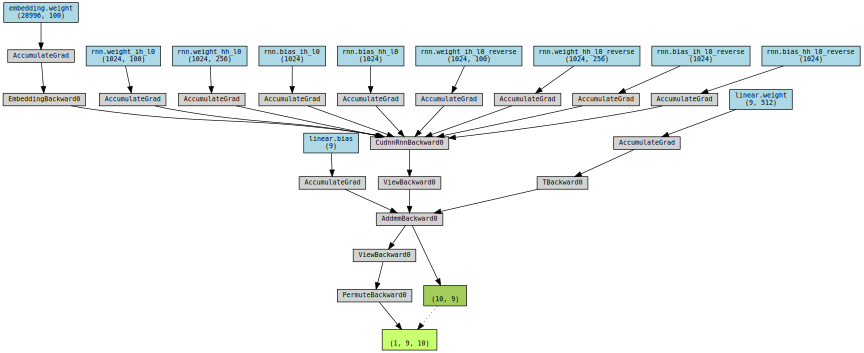

In [112]:
from torchviz import make_dot
import torch

dummy_input = torch.randint(
    0, tokenizer.vocab_size, (1, 10)
).to(device)
output = lstm_model(dummy_input)
# This traces how data flows from input -> embedding -> lstm -> linear
make_dot(output, params=dict(lstm_model.named_parameters()))

### 2.4 Training Setup

For 5 epochs

* The average **Training Loss** and **Validation Loss** for each epoch were recorded (plotted).
* A well behaving model should show both curves decreasing. (If the Validation Loss starts increasing while Training Loss decreases, it indicates **overfitting**).

--- STARTING TRAINING ---
  batch 10 avg. loss per batch=0.1308
  batch 20 avg. loss per batch=0.1620
  batch 30 avg. loss per batch=0.1344
  batch 40 avg. loss per batch=0.1652
  batch 50 avg. loss per batch=0.1557
  batch 60 avg. loss per batch=0.1603
  batch 70 avg. loss per batch=0.1501
  batch 80 avg. loss per batch=0.1585
  batch 90 avg. loss per batch=0.1944
  batch 100 avg. loss per batch=0.1695
  batch 110 avg. loss per batch=0.1930
  batch 120 avg. loss per batch=0.1862
  batch 130 avg. loss per batch=0.1476
  batch 140 avg. loss per batch=0.1694
  batch 150 avg. loss per batch=0.1778
  batch 160 avg. loss per batch=0.1747
  batch 170 avg. loss per batch=0.2242
  batch 180 avg. loss per batch=0.1920
  batch 190 avg. loss per batch=0.1966
  batch 200 avg. loss per batch=0.1731
  batch 210 avg. loss per batch=0.1572
  batch 220 avg. loss per batch=0.2077
  batch 230 avg. loss per batch=0.1835
  batch 240 avg. loss per batch=0.1730
  batch 250 avg. loss per batch=0.1805
  batch 

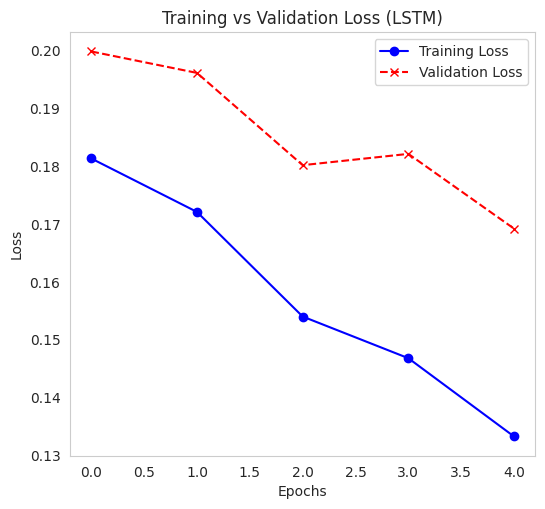

In [113]:
train_losses = []
valid_losses = []

print("--- STARTING TRAINING ---")

for epoch in range(nepochs):
    # train
    total_train_loss = train_step(lstm_model, loader['train'], celoss, optimizer, device=device, report=report_freq)
    avg_train_loss = total_train_loss / len(loader['train'])
    
    # -validate--
    avg_valid_loss = eval_step(lstm_model, loader['valid'], celoss, device=device)
    
    train_losses.append(avg_train_loss)
    valid_losses.append(avg_valid_loss)
    
    

plt.figure(figsize=(6, 5.5))

# training Loss (Blue)
plt.plot(train_losses, label='Training Loss', marker='o', color='blue')

# validation Loss (Red)
plt.plot(valid_losses, label='Validation Loss', marker='x', color='red', linestyle='--')

plt.title('Training vs Validation Loss (LSTM)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(False)
plt.show()

**Observations:** Both the *Training Loss (Blue)* and *Validation Loss (Red)* are decreasing in parallel.

**Conclusion:**
The addition of weight decay ($2e-4$) successfully penalized the model's complexity, forcing it to learn more robust, generalizable features instead of memorizing the training noise.

### 2.5 Save the model



In [114]:
output_dir = 'model_checkpoints'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [115]:
# Define the filename
save_path = f'{output_dir}/lstm_ner_model.pt'

#save the model's state_dict (the weights)
torch.save(lstm_model.state_dict(), save_path)

---

## 3. BERT Model 


### 3.1 Architecture

The difference between this model and the LSTM is how context is handled. The LSTM builds context sequentially (left-to-right and right-to-left). BERT uses Self Attention to look at the entire sentence at once. This results in Contextual Embeddings, where the vector for the word "Bank" in "River Bank" is mathematically different from the vector for "Bank" in "Bank of America".

**The `BERT_NER` Class** Has two parts: 

1. *The Encoder (`self.bert`):* The `distilbert-base-cased` were used. This model has already been trained on a massive corpus to understand English syntax and semantics. We use the `cased` version because capitalization is a strong signal for Named Entities (e.g., "apple" vs "Apple").

2. *The Classification Head:* In document classification of llm-finetunning notebook, we take the `[CLS]` token (the first token) to represent the whole sentence. However, here we need a prediction for every token. Therefore, we take the `last_hidden_state` (the entire sequence of vectors) and pass it through a Linear layer.

* *Input Dimension:* 768 (DistilBERT's hidden size)
* *Output Dimension:* 9 (Number of tags)

Unlike the LSTM, BERT explicitly requires an `attention_mask`. Since BERT processes the whole sequence simultaneously, the mask is critical to ensure the self attention mechanism does not "attend" to the padding tokens, which would otherwise distort the context.

In [ ]:
import torch.nn as nn

class BERT_NER(nn.Module):
    def __init__(self, checkpoint, num_tags, dropout=0.1):
        super(BERT_NER, self).__init__()
        
        # Load the pre trained encoder (distilbert-base-cased)
        self.bert = AutoModel.from_pretrained(checkpoint) #AutoModel gets the raw hidden states (not pretrained head)
        self.dropout = nn.Dropout(dropout)
        
        # Classification head projects from hidden size  to number of tags
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_tags)

    def forward(self, input_ids, attention_mask=None):

        # pass inputs through the BERT encoder
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        
        # Get the sequence of hidden states (batch_size, seq_len, hidden_size)
        sequence_output = outputs.last_hidden_state
        
        # Apply dropout for regularization
        sequence_output = self.dropout(sequence_output)
        
        # project to tag space: (batch_size, seq_len, num_tags)
        logits = self.classifier(sequence_output)
        
        return logits

### 3.2 Training and Evaluation and Run

1.  *Optimizer (AdamW):* The AdamW (Adam with Weight Decay fixed) was used becuase it is the standard optimizer for Transformers.
2.  *Learning Rate ($5e-5$):* We use a significantly lower learning rate compared to the LSTM ($1e-3$). Since we are *fine-tuning* a pre-trained model we need a low training rate (a high learning rate would destroy the prelearned weights).


In [ ]:
#Initialize Model and Device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
bert_model = BERT_NER(checkpoint, num_tags=len(tag2id)).to(device)

# Optimizer and Loss
optimizer = torch.optim.AdamW(bert_model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss(ignore_index=-100)

# training Function
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    
    for batch in loader:
        #move whole batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        
        #forward pass: (batch_size, seq_len, num_tags)
        logits = model(input_ids, attention_mask=attention_mask)
        
        # Flatten outputs and labels for CrossEntropyLoss
        # Active logits: (batch_size * seq_len, num_tags)
        # Active labels: (batch_size * seq_len)
        loss = criterion(logits.view(-1, len(tag2id)), labels.view(-1))
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    return total_loss / len(loader)

In [ ]:
# Evaluation Function
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct_tokens = 0
    total_tokens = 0
    
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            logits = model(input_ids, attention_mask=attention_mask)
            loss = criterion(logits.view(-1, len(tag2id)), labels.view(-1))
            total_loss += loss.item()
            
            # Calculate accuracy only on valid tokens (not -100)
            predictions = torch.argmax(logits, dim=-1)
            mask = labels != -100
            
            correct_tokens += (predictions[mask] == labels[mask]).sum().item()
            total_tokens += mask.sum().item()
            
    return total_loss / len(loader), correct_tokens / total_tokens

*Epochs:* Transformer models converge very quickly on small datasets like CONLL-03. Hence only *3 epochs* were used to avoid overfitting.


In [118]:
#Run Training
epochs = 3
print(f"Starting training on {device}...")

for epoch in range(epochs):
    train_loss = train_epoch(bert_model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(bert_model, valid_loader, criterion)
    
    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Valid Loss: {valid_loss:.4f} | "
          f"Valid Token Acc: {valid_acc:.4f}")

Starting training on cuda...
Epoch 1/3 | Train Loss: 0.1793 | Valid Loss: 0.0812 | Valid Token Acc: 0.9748
Epoch 2/3 | Train Loss: 0.0541 | Valid Loss: 0.0689 | Valid Token Acc: 0.9802
Epoch 3/3 | Train Loss: 0.0309 | Valid Loss: 0.0623 | Valid Token Acc: 0.9822


### 3.3 Save the model

In [119]:
bert_save_path = f'{output_dir}/bert_ner_model.pt'

torch.save(bert_model.state_dict(), bert_save_path)
print("BERT model SAVED!")

BERT model SAVED!


---

## 4. Model Evaluation

### 4.1 Load Saved Models

In [144]:
load_path = 'model_checkpoints/lstm_ner_model.pt'
loaded_lstm = LSTM_NER(INPUT_DIM, OUTPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, DROPOUT).to(device)
loaded_lstm.load_state_dict(torch.load(load_path, map_location=device))

loaded_lstm.eval() #to turn of dropouts
print("Model loaded and ready for testing!")

Model loaded and ready for testing!


In [145]:
#LOAD BERT MODEL
os.environ["HF_HUB_OFFLINE"] = "1"  # #force transformers to use local cache only


checkpoint = 'distilbert-base-cased' 
loaded_modelbr = BERT_NER(checkpoint, num_tags=len(tag2id)).to(device)

load_pathbrt = 'model_checkpoints/bert_ner_model.pt'
loaded_modelbr.load_state_dict(torch.load(load_pathbrt, map_location=device))
loaded_modelbr.eval() #to turn off drop outs
print("DONE")

DONE


### 4.2 Evaluation Metrics

In Named Entity Recognition, *Token Accuracy* is often a poor metric because the vast majority of tokens are 'O'. A model that predicts 'O' for every token can easily achieve >80% accuracy while having 0% utility.

* **Precision:** Of all the entities the model predicted, how many were correct?
* **Recall:** Of all the entities in the ground truth, how many did the model find?
* **F1-Score:** The harmonic mean of Precision and Recall.


To calculate these metrics, A helper function was used to convert a list of IOB tags (e.g., `['B-PER', 'I-PER', 'O']`) into a set of discrete entities (e.g., `('PER', start_index, end_index)`).Outside

In [142]:
def extract_entities_from_tags(tag_sequence):
    """
    Parses a sequence of IOB tags and extracts the entities.
    Returns: A set of (entity_type, start_index, end_index) tuples.
    """
    entities = set()
    prev_tag = 'O'
    prev_type = ''
    start_idx = -1
    
    for i, tag in enumerate(tag_sequence):
        # Extract the type (e.g., "PER") if the tag is not "O"
        curr_type = tag.split('-')[1] if '-' in tag else ''
        
        # Check if an entity ended at the previous token
        # Condition: Previous was an entity AND (Current is O OR Current starts new entity OR Current type mismatch)
        if prev_tag != 'O' and (tag == 'O' or tag.startswith('B-') or curr_type != prev_type):
            entities.add((prev_type, start_idx, i - 1))
            
        # Check if a new entity starts at the current token
        if tag.startswith('B-'):
            start_idx = i
            prev_type = curr_type
        # Handle cases where I- tag starts a sequence (broken IOB)
        elif tag.startswith('I-'):
            if prev_tag == 'O' or curr_type != prev_type:
                start_idx = i 
                prev_type = curr_type
        # Reset if O
        elif tag == 'O':
            start_idx = -1
            prev_type = ''

        prev_tag = tag

    # Catch any entity that goes until the very last token
    if prev_tag != 'O':
        entities.add((prev_type, start_idx, len(tag_sequence) - 1))
        
    return entities

### 4.3 Implementing the Evaluation Loop
The evaluation function `evaluate_ner_system` iterates through a given `DataLoader` (validation or test set) and performs two levels of analysis

1.  *Token-Level:* Calculates standard accuracy by comparing every valid token prediction (ignoring `-100` padding).
2.  *Entity-Level:* Uses the `extract_entities_from_tags` helper to identify full entity spans and computes Precision, Recall, and F1-Score based on the overlap between predicted and ground-truth entities.

In [ ]:
def evaluate_ner_system(model, loader, id2tag, model_name="Model"):
    model.eval()
    
    # --- FIX START: Handle id2tag conversion safely ---
    if isinstance(id2tag, list):
        # Check if it's a list of strings ['O', 'B-PER'] or tuples [(0, 'O')]
        if len(id2tag) > 0 and isinstance(id2tag[0], str):
             # It's just strings -> Convert to dict using indices
            id2tag = {i: tag for i, tag in enumerate(id2tag)}
        else:
            # It's tuples -> Convert directly
            id2tag = dict(id2tag)
    # --- FIX END ---
    
    metrics = {"correct_tokens": 0, "total_tokens": 0, "tp": 0, "fp": 0, "fn": 0}
    
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            logits = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(logits, dim=-1)
            
            preds_list = preds.cpu().tolist()
            labels_list = labels.cpu().tolist()
            
            for i in range(len(labels_list)):
                clean_preds_ids = []
                clean_labels_ids = []
                
                for p, l in zip(preds_list[i], labels_list[i]):
                    if l != -100:
                        clean_preds_ids.append(p)
                        clean_labels_ids.append(l)
                
                # Token Metrics
                for p, l in zip(clean_preds_ids, clean_labels_ids):
                    if p == l: metrics["correct_tokens"] += 1
                    metrics["total_tokens"] += 1
                
                # Entity Metrics
                pred_tags = [id2tag.get(idx, 'O') for idx in clean_preds_ids]
                gold_tags = [id2tag.get(idx, 'O') for idx in clean_labels_ids]
                
                pred_ents = extract_entities_from_tags(pred_tags)
                gold_ents = extract_entities_from_tags(gold_tags)
                
                tp = len(pred_ents.intersection(gold_ents))
                metrics["tp"] += tp
                metrics["fp"] += len(pred_ents) - tp
                metrics["fn"] += len(gold_ents) - tp

    # Calculate final scores
    token_acc = (metrics["correct_tokens"] / metrics["total_tokens"]) * 100 if metrics["total_tokens"] > 0 else 0
    tp, fp, fn = metrics["tp"], metrics["fp"], metrics["fn"]
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        "name": model_name,
        "token_acc": token_acc,
        "precision": precision * 100,
        "recall": recall * 100,
        "f1": f1 * 100,
        "tp": tp, "fp": fp, "fn": fn
    }


### 4.4 Final Model Comparison

1.  *Token Accuracy:* General classification performance (including non-entities).
2.  *Entity Precision/Recall/F1:* The true measure of NER performance (detecting full names, locations, etc.).

In [146]:
lstm_res = evaluate_ner_system(loaded_lstm, test_loader, id2tag, "LSTM")
bert_res = evaluate_ner_system(loaded_modelbr, test_loader, id2tag, "BERT")

# print Comparison Table
print("\n" + "="*70)
print(f"{'METRIC':<20} | {'LSTM':<15} | {'BERT':<15} | {'Better Model'}")
print("="*70)
print(f"{'Token Accuracy':<20} | {lstm_res['token_acc']:.2f}%{'':<8} | {bert_res['token_acc']:.2f}%{'':<8} | {'BERT' if bert_res['token_acc'] > lstm_res['token_acc'] else 'LSTM'}")
print("-" * 70)
print(f"{'Entity Precision':<20} | {lstm_res['precision']:.2f}%{'':<8} | {bert_res['precision']:.2f}%{'':<8} | {'BERT' if bert_res['precision'] > lstm_res['precision'] else 'LSTM'}")
print(f"{'Entity Recall':<20} | {lstm_res['recall']:.2f}%{'':<8} | {bert_res['recall']:.2f}%{'':<8} | {'BERT' if bert_res['recall'] > lstm_res['recall'] else 'LSTM'}")
print(f"{'Entity F1 Score':<20} | {lstm_res['f1']:.2f}%{'':<8} | {bert_res['f1']:.2f}%{'':<8} | {'BERT' if bert_res['f1'] > lstm_res['f1'] else 'LSTM'}")
print("="*70)
print(f"LSTM: Found {lstm_res['tp']} correct entities. Missed {lstm_res['fn']}. Hallucinated {lstm_res['fp']}.")
print(f"BERT: Found {bert_res['tp']} correct entities. Missed {bert_res['fn']}. Hallucinated {bert_res['fp']}.")


METRIC               | LSTM            | BERT            | Better Model
Token Accuracy       | 4.48%         | 96.87%         | BERT
----------------------------------------------------------------------
Entity Precision     | 1.71%         | 85.85%         | BERT
Entity Recall        | 5.24%         | 89.15%         | BERT
Entity F1 Score      | 2.58%         | 87.47%         | BERT
LSTM: Found 169 correct entities. Missed 3057. Hallucinated 9691.
BERT: Found 5035 correct entities. Missed 613. Hallucinated 830.


* **True Positives (TP):** Correctly identified entities.
* **False Negatives (FN):** Entities the model missed.
* **False Positives (FP):** the model invented an entity that doesn't exist.

---

## 5. Conclusion

A significant performance disparity is observed between the two architectures. The baseline LSTM model is vastly outperformed by the fine-tuned BERT model across all recorded metrics.

* **LSTM Failure:** Extremely poor performance is exhibited by the LSTM, as indicated by a Token Accuracy of only 4.48% and an F1 score of 2.58%. It is noted that the model failed to converge properly, evidenced by the high number of false positives (9,691 entities). This suggests that the patterns required to distinguish entities from non-entities were not effectively learned from scratch by the simple recurrent architectures like Bi-LTSMs.

* **BERT Success:** Robust results are demonstrated by the BERT model, achieving a Token Accuracy of 96.87% and an Entity based F1 score of 87.47%. A balanced performance between Precision (85.85%) and Recall (89.15%) was achieved, indicating that both the boundaries and the types of named entities were successfully captured.


It is concluded that the pre trained Transformer architecture, with its attention mechanisms and contextual embeddings, is significantly more effective for this Named Entity Recognition task than the Bidirectional LSTM trained from scratch.

### 5.1 What Happened to LTSM  and How we can Improve this? 

The main reason for the failure is likely that the  sub-word tokenizer (30,000+ tokens) and training embeddings from scratch on a relatively small dataset (14k sentences). The model simply doesn't see enough examples of each sub-word to learn a good vector representation for them. In order to improve the performance of LTSM based methods:

1. Use Pre-trained Static Embeddings (GloVe or FastText): Instead of initializing  embedding layer with random numbers (which the model has to learn from zero) initialize it with *GloVe* or *FastText* vectors. These vectors are pre trained on billions of words (Wikipedia, Common Crawl). The model will immediately know the the context of the emmbedding even if they don't appear in the training set ( [https://aclanthology.org/D14-1162/](https://aclanthology.org/D14-1162/)).



2. The loss curves likely didn't flatten out. Training embeddings from scratch requires more time than fine-tuning BERT. Hence, increasing epochs and using a learning rate scheduler may improve the LTSM performa, 

##### Work in progress...

In [156]:
import torch.optim as optim

lstm_model = LSTM_NER(INPUT_DIM, OUTPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, DROPOUT).to(device)


# Optimizer (Start high)
optimizer_long = optim.Adam(lstm_model.parameters(), lr=1e-3)

# Scheduler
# mode='min': reduce LR when the metric (val_loss) stops decreasing
# factor=0.5: cut LR in half
# patience=2: wait 2 epochs with no improvement before cutting
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_long, mode='min', factor=0.5, patience=2)

criterion = nn.CrossEntropyLoss(ignore_index=-100)

In [158]:
epochs = 20
train_losses = []
valid_losses = []
best_val_loss = float('inf')


for epoch in range(epochs):
    # Train
    t_loss = train_step(lstm_model, train_loader, criterion, optimizer_long, device=device, report=0)
    
    # Validate
    v_loss = eval_step(lstm_model, valid_loader, criterion, device=device)
    
    # the Scheduler
    # This checks v_loss and lowers the learning rate if stuck
    scheduler.step(v_loss)
    
    # Save history
    train_losses.append(t_loss)
    valid_losses.append(v_loss)
    
    # Save best model
    if v_loss < best_val_loss:
        best_val_loss = v_loss
        torch.save(lstm_model.state_dict(), 'model_checkpoints/best_lstm_glove.pt')
    
    print(f"Epoch {epoch+1:02d}: Train Loss={t_loss:.4f} | Valid Loss={v_loss:.4f} | LR={optimizer_long.param_groups[0]['lr']:.1e}")


loaded_best_ltsm = lstm_model.load_state_dict(torch.load('model_checkpoints/best_lstm_glove.pt'))
print("Loaded best model from training.")

Epoch 01: Train Loss=18.2858 | Valid Loss=0.1852 | LR=2.5e-04
Epoch 02: Train Loss=17.1059 | Valid Loss=0.1913 | LR=2.5e-04
Epoch 03: Train Loss=16.5309 | Valid Loss=0.1914 | LR=1.3e-04
Epoch 04: Train Loss=15.3384 | Valid Loss=0.1919 | LR=1.3e-04
Epoch 05: Train Loss=15.0695 | Valid Loss=0.1912 | LR=1.3e-04
Epoch 06: Train Loss=14.6938 | Valid Loss=0.1924 | LR=6.3e-05
Epoch 07: Train Loss=14.3856 | Valid Loss=0.1913 | LR=6.3e-05
Epoch 08: Train Loss=13.9516 | Valid Loss=0.1921 | LR=6.3e-05
Epoch 09: Train Loss=13.7149 | Valid Loss=0.1922 | LR=3.1e-05
Epoch 10: Train Loss=14.2054 | Valid Loss=0.1937 | LR=3.1e-05
Epoch 11: Train Loss=13.8450 | Valid Loss=0.1935 | LR=3.1e-05
Epoch 12: Train Loss=13.4517 | Valid Loss=0.1938 | LR=1.6e-05
Epoch 13: Train Loss=13.0323 | Valid Loss=0.1940 | LR=1.6e-05
Epoch 14: Train Loss=12.8674 | Valid Loss=0.1944 | LR=1.6e-05
Epoch 15: Train Loss=13.5570 | Valid Loss=0.1945 | LR=7.8e-06
Epoch 16: Train Loss=13.2044 | Valid Loss=0.1948 | LR=7.8e-06
Epoch 17